<div style='color:white;font-size:30px;background-color:#196363;text-align:center;padding-top:20px; padding-bottom:20px;margin-bottom:40px'>VERSIFICATION & AUTHORSHIP ATTRIBUTION</div>
<h1>4.2 The case of (pseudo-)Batenkov:<br> Towards a formal proof of literary forgery</h1>
<h2 style='margin-bottom: 50px'>Replication code</h2>

In [2]:
import itertools
import json
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import random
import seaborn as sns
import sticho
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy import stats

<h3>Read data from JSON</h3>

In [3]:
#----------------------------------------------------------------------------------------------------------#
# File contains a list of poems with following structure:                                                  #   
# [{                                                                                                       #
#    'author': string (name of the author),                                                                #
#    'title': string (title of the poem),                                                                  #
#    'year': int (year of publication, 0 if unkown)                                                        #
#    'body': [{                                                                                            #
#        'text': string (text of the line)                                                                 #
#        'metre': string (metre of the line)                                                               #
#        'stress_pattern': string (string representing distribution of stressed/unstressed and             #
#                          word-initial/word-non-initial syllables):                                       #
#                          'I':  stressed / initial                                                        #
#                          'i':  stressed / non-initial                                                    #
#                          'O':  unstressed / initial                                                      #
#                          'o':  unstressed / non-initial                                                  #
#        'rhyme': list (indices of lines with which this one rhymes)                                       #
#        'subcorpus': int (1: 1820s subcorpus, 2: 1840s-1850s subcorpus + Ilyushin)                        #
#        'words': [{                                                                                       #
#            'token': string,                                                                              #
#            'lemma': string,                                                                              #
#            'tag': string (POS-tag)                                                                       #
#            'xsampa': string (phonetic transcription of word in XSampa - line-final words only)           #
#         }, ...]                                                                                          #
#     }, ... ]                                                                                             #
# }, ...]                                                                                                  #
#                                                                                                          #
# NOTE: In Ilyushin's poems metre recognition was not preformed. [metre] attribute provides                #
#       information only on clausula (first two chars are always X0) and [stress_pattern] attribute        #
#       provides only information on final stress interval in the format of a regular bit string           #
#       (it's a substring of proper stress pattern starting with last "1").                                #
#                                                                                                          #
# Dataset comes from The Russian Poetic Corpus (http://www.ruscorpora.ru/new/en/).                         #
# Tokenization, lemmatization, pos-tagging provided by MyStem (https://yandex.ru/dev/mystem/).             #
# Phonetic transcription provided by ESpeak (http://espeak.sourceforge.net/)                               #
#----------------------------------------------------------------------------------------------------------#

with open('data/batenkov.json', 'r') as f:
    data = json.load(f)

<h3>Functions</h3>

In [5]:
def delta(df, metric, output='accuracy'):
    '''
    Count Burrows' delta
    :: df     =  pandas DataFrame (document vectors)
    :: metric =  string ('cosine' | 'euclidean' | 'manhattan')
    :: output =  string ('accuracy' | 'distance_matrix' )
    '''

    # Create distance matrix
    dist_matrix = pd.DataFrame(data=squareform(pdist(df, metric)), columns=df.index, index=df.index)
    np.fill_diagonal(dist_matrix.values, np.nan)

    # Iterate over distance matrix to get accuracy
    acc = 0
    for sample in dist_matrix.index:       
        nn = dist_matrix[sample].sort_values().index[0][0]
        # Increase accuracy if nearest neighbour is the actual author
        if sample[0] == nn:
            acc += 1/len(dist_matrix.index)
            
    if output == 'accuracy':
        return acc 
    elif output == 'distance_matrix':
        return dist_matrix

def svm(df):
    '''
    Leave-one-out cross-validation with linear SVM
    :: df     =  pandas DataFrame (document vectors)
    '''
    
    c = sticho.Classification(df, clf='svm', kernel='linear', C=1)
    acc = c.cross_validation()
    return acc    
    
def text2vec(s, domain, mft):
    '''
    A little shortcut to extract features
    :: s       = instance of Sampler class (containing samples)
    :: domain  = string (which feature set to include: 'l': lemmata, 'g': char 3grams, 'r': rhyme - 
                         may be combined, e.g. 'lgr' for all feature sets )
    :: mft     = int (number of most frequent types for lexical features)
    '''
    
    f = sticho.Features(s)
    if 'l' in domain:
        f.bow(domain='lemma', mft=mft)
    if 'g' in domain:
        f.char_ngrams(n=3, mft=mft)
    if 'r' in domain:
        f.rhyme_profile(method='word_length', mft=20, ending='мж')
        f.rhyme_profile(method='stress', mft=20, ending='мж')
        f.rhyme_profile(method='pos', mft=40, ending='мж')
        f.rhyme_profile(method='sounds', mft=40, ending='мж', snd_position=1)
        f.rhyme_profile(method='sounds', mft=10, ending='мж', snd_position=2)
    f.build_dataframe()
    return f.df_   

<h2>4.2.2 Fine-tuning</h2>

<p> We first test the performance of lemmata-based (L), 3-gram-based (G), and rhyme-based (R) models and their combinations LG and LGR with different settings of MFT on 1820s poems. (30 iterations with randomly picked 10 samples per each author.)
<p> → The combination of LGR tends to outperform that of LG.

In [19]:
# Print authors in test-corpus and number of samples available
s = sticho.Sampler(data, n=200, subcorpus=1, meters=None, min_rhymes=80)
for a in s.samples_:
    print('{0} ({1})'.format(a, len(s.samples_[a])), end=' ')

Vyazemsky (12) Lermontov (23) Zhukovsky (11) Yazykov (36) Pushkin (60) Baratynsky (19) 

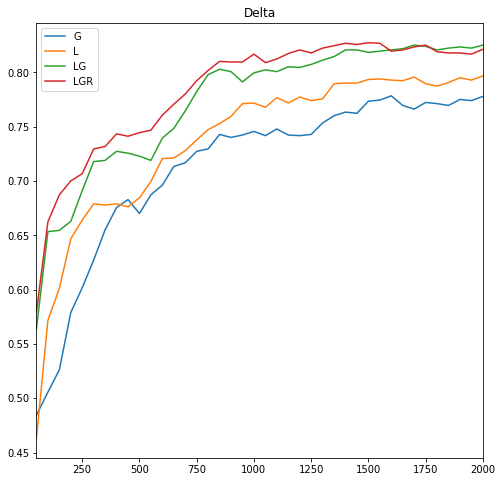

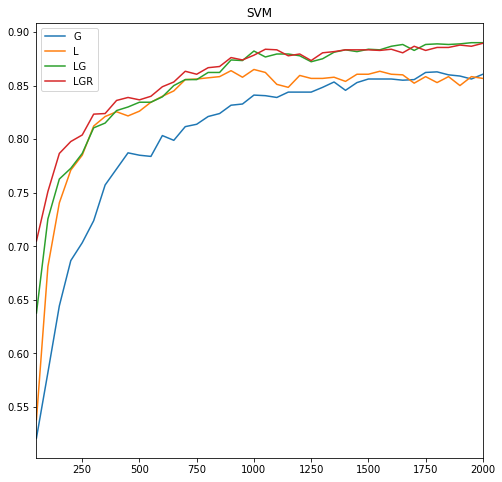

In [20]:
# Number of iterations
iterations = 30
# Container to store the accuracies
acc_delta = defaultdict(lambda: defaultdict(int))
acc_svm = defaultdict(lambda: defaultdict(int))

# Perform required number of iterations
for iteration in range(iterations):
    
    # Extract samples
    s = sticho.Sampler(data, n=200, subcorpus=1, meters=None, min_rhymes=80)

    # Randomly pick 10 samples by each author
    s.level_samples(max_=10)

    # Iterate over 50, 100, 150, ..., 2000 most frequent types
    for mft in [x*50 for x in range(1, 41)]:
        print('iteration #{0} | mft = {1}    '.format(iteration+1, mft), end='\r')

        # Classification with L
        df_l = text2vec(s, domain='l', mft=mft) 
        acc_delta['L'][mft] += delta(df_l, 'cosine') / iterations
        acc_svm['L'][mft] += svm(df_l) / iterations        

        # Classification with G
        df_g = text2vec(s, domain='g', mft=mft) 
        acc_delta['G'][mft] += delta(df_g, 'cosine') / iterations
        acc_svm['G'][mft] += svm(df_g) / iterations

        # Classification with LG    
        df_lg = pd.concat([df_l, df_g], axis=1, sort=False)
        acc_delta['LG'][mft] += delta(df_lg,  'cosine') / iterations
        acc_svm['LG'][mft] += svm(df_lg) / iterations

        # Classification with LGR
        df_r = text2vec(s, domain='r', mft=None)    
        df_lgr = pd.concat([df_lg, df_r], axis=1, sort=False)
        acc_delta['LGR'][mft] += delta(df_lgr,  'cosine') / iterations
        acc_svm['LGR'][mft] += svm(df_lgr) / iterations

# Plot charts
print(' '*40, end='\r')
df = pd.DataFrame.from_dict(acc_delta)
df.plot.line(figsize=(8,8), title='Delta');
df = pd.DataFrame.from_dict(acc_svm)
df.plot.line(figsize=(8,8), title='SVM');

<h2>4.2.3 The one-class problem (authorship verification)</h2>

In [22]:
iterations = 30
accs = defaultdict(lambda: defaultdict(list))

# Iterate over MFT = 50, 100, 150, ..., 1000
for mft in [x*50 for x in range(1, 21)]:
    # Perform required number of random iterations
    for iteration in range(iterations): 
        print('MFT={0} | iteration #{1}    '.format(mft, iteration+1), end='\r')

        # Extract 6 samples by Batenkov and 12 samples by other authors
        s = sticho.Sampler(data, n=100,  subcorpus=2, meters=None, min_rhymes=40, year_min=1840, year_max=1860)
        sb = sticho.Sampler(data, n=100,  subcorpus=3, meters=None, min_rhymes=40)
        for a in sb.samples_:
            for i in sb.samples_[a]:
                s.samples_[a][i+4] = sb.samples_[a][i]
        s.level_samples(max_=12, exceptions=['Batenkov'])

        # Randomly split these 12 samples into group A and group B
        a_samples = defaultdict(dict)
        b_samples = defaultdict(dict)
        for a in s.samples_:
            if a == 'Batenkov':
                a_samples[a] = s.samples_[a]
                continue
            samples_list = s.samples_[a].keys()
            group_a = random.sample(samples_list, 6)
            for sample in samples_list:
                if sample in group_a:
                    a_samples[a][sample] = s.samples_[a][sample]
                else:
                    b_samples[a+"2"][sample] = s.samples_[a][sample]

        # Perform classification author vs. another author
        pairs = list(itertools.combinations(a_samples, 2))
        for ip, pair in enumerate(pairs):
            sb.samples_ = {pair[0]: a_samples[pair[0]], pair[1]: a_samples[pair[1]]}
            df = text2vec(sb, domain='lgr', mft=mft)   
            c = sticho.Classification(df, clf='svm', kernel='linear', C=1)
            acc = c.cross_validation()
            accs[mft]['diff'].append(acc)

        # Perform classification author vs. same author
        for author in a_samples:
            if author == 'Batenkov':
                continue
            sb.samples_ = {author: a_samples[author], author+'2': b_samples[author+'2']}
            df = text2vec(sb, domain='lgr', mft=mft)   
            c = sticho.Classification(df, clf='svm', kernel='linear', C=1)
            acc = c.cross_validation()
            accs[mft]['same'].append(acc)

    # Perform classification Batenkov vs. Pseudo-Batenkov    
    s = sticho.Sampler(data, n=100,  authors='PseudoBatenkov', meters=None, min_rhymes=40)
    sb.samples_ = {'Batenkov': a_samples['Batenkov'], 'PseudoBatenkov': s.samples_['PseudoBatenkov']}
    df = text2vec(sb, domain='lgr', mft=mft)   
    c = sticho.Classification(df, clf='svm', kernel='linear', C=1)
    accs[mft]['pb'] = c.cross_validation()

print('done', ' '*40)

done                                         


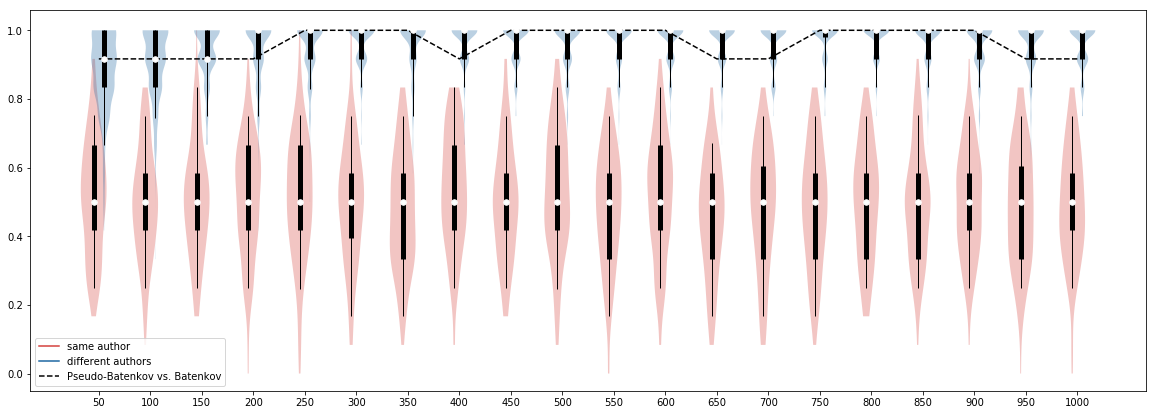

In [53]:
plotdata = defaultdict(list)
for mft in sorted(accs):
    plotdata['ticks'].append(mft)
    plotdata['pb'].append(accs[mft]['pb'])
    plotdata['same'].append(accs[mft]['same'])
    plotdata['diff'].append(accs[mft]['diff'])
    
plt.figure(figsize=(20, 7))

# Color palette
plotcolors = {
    'diff': '#1B65A1',
    'same': '#D43F3A',
    'pb': 'black',
}

# Set shift from xticks for particluar series 
shifts = {
    'diff': 0.1,
    'same': -0.1,
}

# X-axis values
inds = np.arange(0, len(plotdata['same']))

# Plot line for Pseudo-Batenkov
plt.plot(inds, plotdata['pb'], color='black', linestyle='dashed')    

# Create violin plots
violins = {
    'same': plt.violinplot(plotdata['same'], positions=inds+shifts['same'],
                         showmeans=False, showmedians=False, showextrema=False),
    'diff': plt.violinplot(plotdata['diff'], positions=inds+shifts['diff'],
                         showmeans=False, showmedians=False, showextrema=False),
}

# Set violin colors
for series in violins:
    for pc in violins[series]['bodies']:
        pc.set_facecolor(plotcolors[series])
        #pc.set_edgecolor('black')
        #pc.set_alpha(1)
        
# Add boxplots
for series in violins:
    
    percentile5, quartile1, medians, quartile3, percentile95 = np.percentile(plotdata[series], 
                                                                             [5, 25, 50, 75, 95], axis=1)
    inds = np.arange(0, len(medians))
    plt.scatter(inds+shifts[series], medians, marker='o', color='white', s=30, zorder=3)
    plt.vlines(inds+shifts[series], quartile1, quartile3, color='k', linestyle='-', lw=5)
    plt.vlines(inds+shifts[series], percentile5, percentile95, color='k', linestyle='-', lw=1)

# Legend and x-axis labels
plt.plot([], c=plotcolors['same'], label='same author')
plt.plot([], c=plotcolors['diff'], label='different authors')
plt.plot([], c='black', label='Pseudo-Batenkov vs. Batenkov', linestyle='dashed')
plt.legend()
plt.xticks(range(len(plotdata['ticks'])), plotdata['ticks']);

plt.savefig('unmasking.svg')

In [50]:
# Mann-Whitney U-test
merged = { 'same': list(), 'diff': list(), 'pb': list()}

for mft in sorted(accs):
    merged['same'].extend(accs[mft]['same'])
    merged['diff'].extend(accs[mft]['diff'])
    merged['pb'].append(accs[mft]['pb'])
        
p_same = stats.mannwhitneyu(merged['same'], merged['pb'], alternative='two-sided')[1]
p_diff = stats.mannwhitneyu(merged['diff'], merged['pb'], alternative='two-sided')[1]
print('p(same) =', p_same)
print('p(diff) =', p_diff)

p(same) = 8.917297313107699e-15
p(diff) = 0.9264955336076555


<h2>4.2.4 The two-class problem (Batenkov vs. Iliushin)</h2>

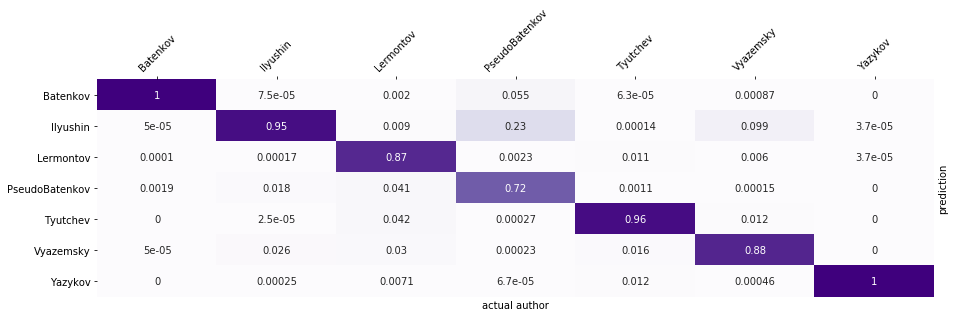

In [6]:
iterations = 10000
mft = 1000
decisions = defaultdict(lambda: defaultdict(int))

# Extract samples
s = sticho.Sampler(data, n=200, subcorpus=2, meters=None, min_rhymes=80)

# Extract features
df = text2vec(s, domain='lgr', mft=mft) 

# Randomly drop n features in n iterations
for iteration in range(iterations):
    print('iteration #{}'.format(iteration+1), end='\r')
    
    features = df.columns.tolist()
    random_n = random.randint(0,1000)
    features_to_drop = random.sample(features, random_n)
    df2 = df.drop(features_to_drop, axis = 1)
    dist_matrix = delta(df2, 'cosine', output='distance_matrix') #.fillna(0)    
    for sample in dist_matrix.index:
        nn = dist_matrix[sample].sort_values().index[0][0]
        decisions[sample[0]][nn] += 1 
    
print(' '*20, end='\r')
# Transform dict with decisions to dataframe
confusion_matrix = pd.DataFrame.from_dict(decisions).fillna(0)
# Divide cells by sum of columns to get relative numbers      
confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=0), axis=1)
# Plot the heatmap
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax = sns.heatmap(confusion_matrix, cbar=False, cmap='Purples', annot=True)
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('actual author')
ax.set_ylabel('prediction')
ax.yaxis.set_label_position("right")

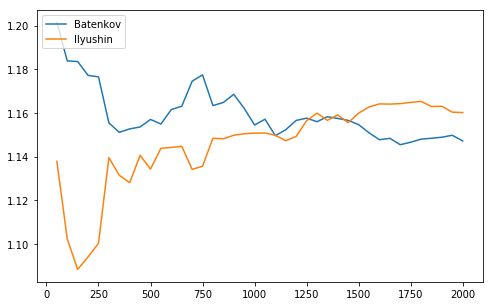

In [10]:
data2 = [x for x in data if x['author'] != 'Ilyushin' or x['title'] in ('sidorin_grek', 'sidorin_vampir')]
s = sticho.Sampler(data2, entire_work=True,  subcorpus=2, meters=None, min_rhymes=180)

dists = defaultdict(list)

for mft in [x*50 for x in range(1, 41)]:
    print('mft {}    '.format(mft), end='\r')


    df = text2vec(s, domain='lgr', mft=mft)    
    dm = delta(df, 'cosine', output='distance_matrix')

    dists['batenkov'].append(dm.at[("Batenkov", 0),("PseudoBatenkov", 0)])
    dists['ilyushin'].append(dm.at[("Ilyushin", 0),("PseudoBatenkov", 0)])  
    
plt.figure(num = 3, figsize=(8, 5))
x = [x*50 for x in range(1, 41)]
plt.plot(x, dists['batenkov'], label='Batenkov')
plt.plot(x, dists['ilyushin'], label='Ilyushin')
plt.legend(loc="upper left")
plt.show()